# Imports

In [26]:
from skimage import filters
from skimage import io, color
import numpy as np
from scipy.ndimage import convolve, maximum_filter
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #avoid annoying imshow deprecated
import math
from typing import Literal
from tqdm import tqdm
import torch

import utils

# Simple data loading / sanity checking

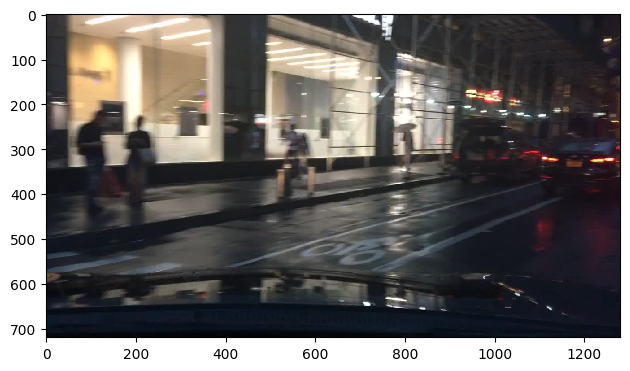

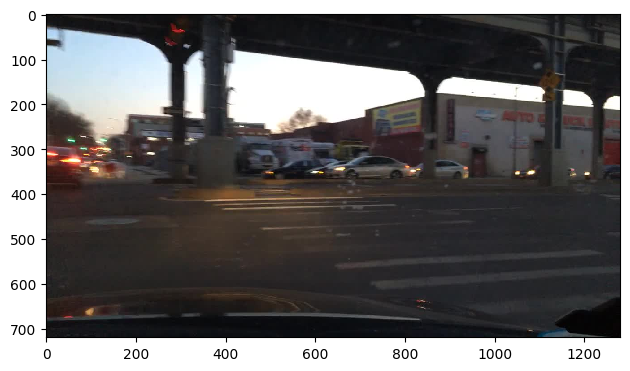

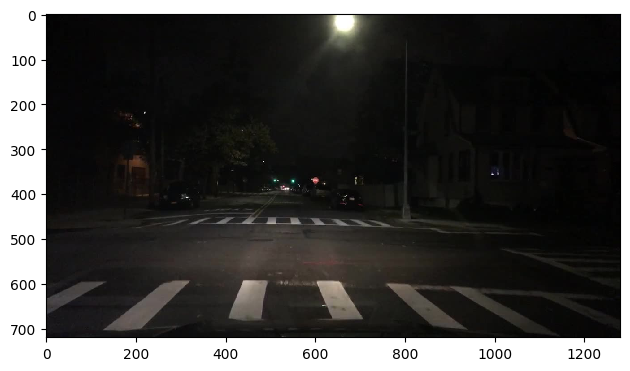

In [27]:
sample_images = utils.get_sample_images()
utils.plot_sample_images(sample_images[:3])

In [28]:
sample_img = sample_images[1]

sample_img.shape #row x col x color

(720, 1280, 3)

In [29]:
sample_img

array([[[32, 32, 32],
        [32, 32, 32],
        [31, 31, 31],
        ...,
        [29, 29, 31],
        [30, 30, 32],
        [31, 31, 33]],

       [[26, 26, 26],
        [26, 26, 26],
        [25, 25, 25],
        ...,
        [29, 29, 31],
        [30, 30, 32],
        [31, 31, 33]],

       [[20, 20, 20],
        [20, 20, 20],
        [19, 19, 19],
        ...,
        [29, 29, 31],
        [30, 30, 32],
        [31, 31, 33]],

       ...,

       [[18, 18, 20],
        [18, 18, 20],
        [20, 20, 22],
        ...,
        [ 8,  6,  7],
        [12, 10, 11],
        [14, 12, 13]],

       [[17, 17, 19],
        [18, 18, 20],
        [19, 19, 21],
        ...,
        [ 9,  7,  8],
        [13, 11, 12],
        [15, 13, 14]],

       [[16, 16, 18],
        [17, 17, 19],
        [19, 19, 21],
        ...,
        [ 9,  7,  8],
        [13, 11, 12],
        [15, 13, 14]]], shape=(720, 1280, 3), dtype=uint8)

In [30]:
len(sample_img[0,:,0]) #one col, should be 1280

1280

In [31]:
sample_img[0,0,:] #one rbg point

array([32, 32, 32], dtype=uint8)

# K-means clustering

100%|██████████| 5/5 [02:16<00:00, 27.33s/it]


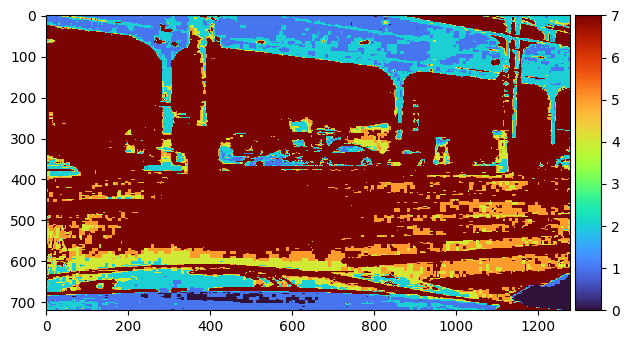

In [32]:
def segment_image_KMeans(
    image: np.ndarray,
    k: int = 10,
    max_iter: int = 300,
    distance_fn: Literal['L2', 'L1', 'cos'] = 'L2',
    restarts: int = 1, #TODO: can implement if cluster quality poor
):
    """Implementation to segment image with kmeans. centroids are initialized to k random data points.
    
    image: image to cluster
    k: number of clusters
    max_iter: stop updating centroids once iterated this many times
    restarts: number of times to run algorithm, choose best clustering
    distance_fn: how to assign datapoint to centroid and verify quality of clusters
    """
    ROWS, COLS, CHANNELS = image.shape

    assert distance_fn in ['L2', 'L1', 'cos'], 'invalid distance fn'
    assert CHANNELS==3, 'color channels not equal to 3'

    flattened_img = image.reshape(-1, 3)
    num_pxs, _ = flattened_img.shape

    centroid_start_indices = np.random.randint(0, num_pxs, size=k)
    centroids = flattened_img[centroid_start_indices]

    labels = np.zeros(num_pxs, dtype=int)
    for i in tqdm(range(max_iter)):
        old_labels = labels.copy()
        #assignment step:
        for i, px in enumerate(flattened_img):
            distances = [utils.compute_distance(px, centroid, distance_fn) for centroid in centroids]
            labels[i] = np.argmin(distances)

        #update step:
        for cluster in range(k):
            cluster_pts = flattened_img[labels == cluster]
            if len(cluster_pts) > 0:
                centroids[cluster] = cluster_pts.mean(axis=0)

        if np.allclose(old_labels, labels): break #k_means finished

    return labels.reshape(ROWS, COLS)

res = segment_image_KMeans(image=sample_img, max_iter=5)

io.imshow(res, cmap='turbo') ; plt.show()

# Insanely slow
Also note only ran for iter =5 \
lets try to speed up with vectorization

100%|██████████| 50/50 [00:09<00:00,  5.36it/s]


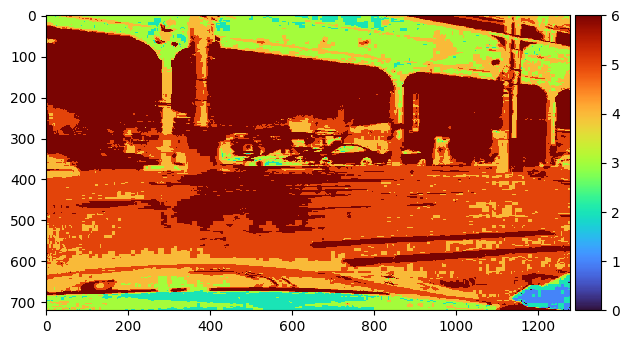

In [33]:
import utils
def segment_image_KMeans_vectorized(
    image: np.ndarray,
    k: int = 10,
    max_iter: int = 50,
    distance_fn: Literal['L2', 'L1', 'cos'] = 'L2',
    restarts: int = 1, #TODO: can implement if cluster quality poor
):
    """Implementation to segment image with kmeans. centroids are initialized to k random data points.
    
    image: image to cluster
    k: number of clusters
    max_iter: stop updating centroids once iterated this many times
    restarts: number of times to run algorithm, choose best clustering
    distance_fn: how to assign datapoint to centroid and verify quality of clusters
    """
    ROWS, COLS, CHANNELS = image.shape

    assert distance_fn in ['L2', 'L1', 'cos'], 'invalid distance fn'
    assert CHANNELS==3, 'color channels not equal to 3'

    flattened_img = image.reshape(-1, 3)
    num_pxs, _ = flattened_img.shape

    centroid_start_indices = np.random.choice(num_pxs, size=k, replace=False)
    centroids = flattened_img[centroid_start_indices].astype(float)

    labels = np.zeros(num_pxs, dtype=int)
    for i in tqdm(range(max_iter)):
        old_labels = labels.copy()
        #assignment step (vectorized):
        px = flattened_img[:, None, :]
        cn = centroids[None, :, :]

        dists = utils.compute_distance(px, cn, distance_fn)
        labels = np.argmin(dists, axis=1)

        #update step:
        for cluster in range(k):
            mask = (labels==cluster)
            if np.any(mask):
                centroids[cluster] = px[mask].mean(axis=0)
            else:
                random_idx = np.random.randint(0, num_pxs)
                centroids[cluster] = flattened_img[random_idx].astype(float) 

        if np.allclose(old_labels, labels): break #k_means finished

    return labels.reshape(ROWS, COLS)

res = segment_image_KMeans_vectorized(image=sample_img, max_iter=50)

io.imshow(res, cmap='turbo') ; plt.show()

# Much faster
Note 50 iterations \
Lets try to leverage gpu with torch

100%|██████████| 50/50 [00:00<00:00, 96.81it/s]


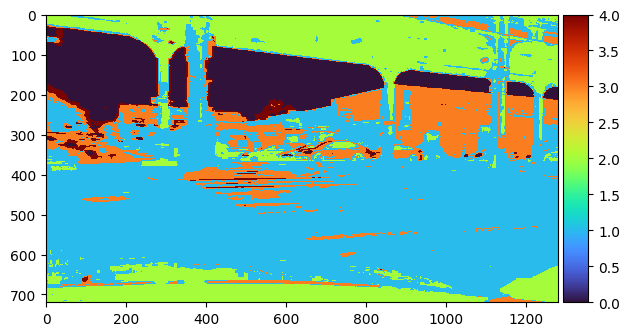

In [34]:
def segment_image_KMeans_torch(
    image: np.ndarray,
    k: int = 5,
    max_iter: int = 50,
    distance_fn: Literal['L2', 'L1', 'cos'] = 'L2',
    restarts: int = 1, #TODO: can implement if cluster quality poor
):
    device = torch.device('mps')
    img = torch.from_numpy(image).float().to(device)
    ROWS, COLS, CHANNELS = img.shape
    assert CHANNELS == 3

    flattened = img.reshape(-1, 3)
    N = flattened.shape[0]

    indices = torch.randint(0, N, (k,), device=device)
    centroids = flattened[indices]

    for _ in tqdm(range(max_iter)):
        old_centroids = centroids.clone()

        #assignment step (torch):
        px = flattened[:, None, :]
        cn = centroids[None, :, :]
        
        dists = utils.compute_distance(px, cn, distance_fn)
        labels = torch.argmin(dists, dim=1)

        #update step (torch):
        sums = torch.zeros((k, 3), device=device)
        counts = torch.zeros((k, 1), device=device)
        sums.index_add_(0, labels, flattened)
        counts.index_add_(0, labels, torch.ones((N, 1), device=device))

        active_mask = counts.squeeze() > 0
        centroids[active_mask] = sums[active_mask] / counts[active_mask]
        inactive_mask = ~active_mask

        if inactive_mask.any():
            num_dead = inactive_mask.sum()
            new_indices = torch.randint(0, N, (num_dead,), device=device)
            centroids[inactive_mask] = flattened[new_indices]

        if torch.allclose(centroids, old_centroids): break

    return labels.cpu().reshape(ROWS, COLS).numpy()

res = segment_image_KMeans_torch(image=sample_img, max_iter=50)

io.imshow(res, cmap='turbo') ; plt.show()

In [ ]:
#for some reason struggling to import compute_FPS from util, probably need to restart kernel, but dont want to run unvectorized again
import time
MINUTE:int = 60
def compute_FPS(algorithm: callable, **alg_kwargs):
    start = time.perf_counter()
    end = start + MINUTE
    i = 0
    
    while time.perf_counter() < end:
        algorithm(**alg_kwargs)
        i+=1

    return  i / MINUTE

num_vectorized =compute_FPS(segment_image_KMeans_vectorized, image=sample_img)
num_torch = compute_FPS(segment_image_KMeans_torch, image=sample_img)

print(f'FPS for vectorized {num_vectorized}')
print(f'FPS for torch {num_torch}')

100%|██████████| 50/50 [00:00<00:00, 99.07it/s]

FPS for vectorized 0.13333333333333333
FPS for torch 1.95


Note 50 iterations, vs Aarons 20